# Imports

In [1]:
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from patchify import patchify

# Create patchify dataset

## Functions

In [2]:
def padder(image, patch_size):
    """
    Adds padding to an image to make its dimensions divisible by a specified patch size.

    This function calculates the amount of padding needed for both the height and width of an image so that its dimensions become divisible by the given patch size. The padding is applied evenly to both sides of each dimension (top and bottom for height, left and right for width). If the padding amount is odd, one extra pixel is added to the bottom or right side. The padding color is set to black (0, 0, 0).

    Parameters:
    - image (numpy.ndarray): The input image as a NumPy array. Expected shape is (height, width, channels).
    - patch_size (int): The patch size to which the image dimensions should be divisible. It's applied to both height and width.

    Returns:
    - numpy.ndarray: The padded image as a NumPy array with the same number of channels as the input. Its dimensions are adjusted to be divisible by the specified patch size.

    Example:
    - padded_image = padder(cv2.imread('example.jpg'), 128)

    """
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding
    
    if image.ndim == 2:
        border_val = 0
    else:
        border_val = [0, 0, 0]

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
def extract_dish(img):
    # height, widh, center of image
    height, widh = img.shape[:2]
    center = (widh // 2, height // 2)

    # convert to grayscale for Otsu
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply Otsu thresholding
    th, output_im = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    print(f'Otsu algorithm selected the following threshold: {th}')

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(output_im)

    # the biggest blob (object) on each image is Petri dish
    # -infinity - to ensure any score is better
    best_label, best_score = None, -np.inf

    # in loop center is used since Petri dish is near center
    for lab in range(1, num_labels):
        """
        range(1...) - skip label 0 as it is the background
        stats are in format: [x, y, w, h, area] where:
            x.y - top-left corner
            w,h - width and height
            area - area in pixels
        centroids are in format: [cx, cy]
        """
        x, y, w, h, area = stats[lab]
        cx, cy = centroids[lab]

        # big area, near center, square shape
        area_score = area
        center_score = -np.linalg.norm([cx - widh/2, cy - height/2])
        
        #checking aspect ratio
        aspect = w / h
        square_score = -abs(aspect - 1.0)

        # check scores weights (area, square, center)
        score = (1.0 * area_score + 500.0 * square_score + 1000.0 * center_score)

        if score > best_score:
            best_score, best_label = score, lab
    
    x, y, w, h, area = stats[best_label]

    # ensure square that the Pertri dish is fully inside margin is added
    margin = 20
    x0 = max(x - margin, 0)
    y0 = max(y - margin, 0)

    # crop
    side = min(w, h)
    x1 = x + side + margin
    y1 = y + side + margin
    extracted_img = img[y0:y1, x0:x1, :]

    # check crop is square
    assert extracted_img.shape[0] == extracted_img.shape[1], "Crop is not square!"
    return extracted_img, (y0, y1, x0, x1)

## Singleclass segmentation

### Create and save patches

In [4]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
patch_dir = 'dataset_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [5]:
def create_and_save_patches(patch_size, scaling_factor):
    roots = ["Y2B_23", "Y2B_24", "Y2B_25"]

    for ds in roots:
        image_split_pairs = []  # list of (image_path, split) where split is "train" or "val"

        # COLLECT IMAGE PATHS + DECIDE SPLIT
        if ds == "Y2B_23":
            # images in subfolders "train", "val", "test" -> ALL go to TRAIN split
            img_root = f"../Task_2/datasets/{ds}/images"
            images = []
            for sub in ["train", "test"]:
                images.extend(glob.glob(os.path.join(img_root, sub, "*.png")))
            images = sorted(images)
            image_split_pairs = [(p, "train") for p in images]

        elif ds == "Y2B_24":
            # images in one folder -> ALL go to TRAIN split
            img_root = f"../Task_2/datasets/{ds}/images"
            all_images = sorted(glob.glob(os.path.join(img_root, "*.png")))
            image_split_pairs = [(p, "train") for p in all_images]

        elif ds == "Y2B_25":
            # filenames start with "train" or "val" -> route accordingly
            img_root = f"../Task_2/datasets/{ds}/images"
            all_images = sorted(glob.glob(os.path.join(img_root, "*.png")))
            for p in all_images:
                fname = os.path.basename(p)
                if fname.startswith("train"):
                    split = "train"
                elif fname.startswith("val"):
                    split = "val"
                else:
                    print(f"[{ds}] Skipping {fname}: unknown split prefix (expected 'train' or 'val').")
                    continue
                image_split_pairs.append((p, split))

        else:
            continue

        mask_root = f"../Task_2/datasets/{ds}/masks"

        # PROCESS EACH IMAGE
        for image_path, split in image_split_pairs:
            base = os.path.basename(image_path)
            stem, _ = os.path.splitext(base)

            # find root mask path
            if ds == "Y2B_23":
                root_mask_path = os.path.join(mask_root, stem + "_root_mask.tif")
                if not os.path.exists(root_mask_path):
                    print(f"Mask(s) missing for {stem}, skipping.")
                    continue
            else:
                # Y2B_24 and Y2B_25: masks are inside subfolders
                root_candidates = glob.glob(os.path.join(mask_root, "*", stem + "_root_mask.tif"))
                if not root_candidates:
                    print(f"Mask(s) missing for {stem}, skipping.")
                    continue
                root_mask_path = root_candidates[0]

            if not os.path.exists(root_mask_path):
                print(f"Mask not found: {stem}_root_mask.tif")
                continue

            # open image and its mask
            image = cv2.imread(image_path)
            root_mask = cv2.imread(root_mask_path, cv2.IMREAD_GRAYSCALE)

            # extract_dish - less computation in future
            image_cropped, (y0, y1, x0, x1) = extract_dish(image)
            root_cropped = root_mask[y0:y1, x0:x1]

            # pad -> square image REQUIREMENT
            image_cropped = padder(image_cropped, patch_size)
            root_cropped = padder(root_cropped, patch_size)

            # scaling (if needed)
            if scaling_factor != 1:
                image_cropped = cv2.resize(
                    image_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )
                root_cropped = cv2.resize(
                    root_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )

            # patchify image
            img_patches = patchify(image_cropped, (patch_size, patch_size, 3), step=patch_size)
            img_patches = img_patches.reshape(-1, patch_size, patch_size, 3)

            # patchify mask
            mask_patches = patchify(root_cropped, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # OUTPUT SUBDIRS BASED ON SPLIT for Y2B_25 ONLY
            if split == "train":
                img_subdir  = "train_images/train"
                mask_subdir = "train_masks/train"
            elif split == "val":
                img_subdir  = "val_images/val"
                mask_subdir = "val_masks/val"
            else:
                raise ValueError(f"Unknown split: {split}")

            # base output paths
            image_patch_base = os.path.join(patch_dir, img_subdir, stem)
            mask_patch_base  = os.path.join(patch_dir, mask_subdir, stem + "_root_mask")

            # save image patches
            for i, patch in enumerate(img_patches):
                out_path = f"{image_patch_base}_{i}.png"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)

            # save mask patches
            for i, patch in enumerate(mask_patches):
                out_path = f"{mask_patch_base}_{i}.tif"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)


Checking the most feasible size of patches

In [6]:
2804/256

10.953125

In [7]:
patch_size = 256
scaling_factor = 1

create_and_save_patches(patch_size, scaling_factor)

Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 98.0
Otsu algorithm selected the following threshold: 98.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 103.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Mask(s) miss

In [8]:
img_paths = sorted(glob.glob("dataset_patched\\train_images\\train\\*.png"))
mask_paths = sorted(glob.glob("dataset_patched\\train_masks\\train\\*.tif"))

print(f"Number of images: {len(img_paths)}")
print(f"Number of masks: {len(mask_paths)}")

Number of images: 57475
Number of masks: 57475


### Small seedlings dataset

#### Mask conversion to .tif

In [16]:
from PIL import Image
import os

input_dir = "..\Task_2\datasets\small_seedlings"
output_dir = "..\Task_2\datasets\small_seedlings_fixed\masks"

os.makedirs(output_dir, exist_ok=True)

THR = 160

for filename in os.listdir(input_dir):
    if filename.endswith("seed.png") or filename.endswith("root.png"):
        in_path = os.path.join(input_dir, filename)
        img = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"Could not read {in_path}, skipping.")
            continue

        # binarize: 0 (background) / 255 (foreground)
        _, binary = cv2.threshold(img, THR, 255, cv2.THRESH_BINARY)
        binary =  255 - binary # invert: background is black (0), foreground is white (255)

        # Convert to TIF
        tif_name = filename.replace(".png", ".tif")
        out_path = os.path.join(output_dir, tif_name)

        cv2.imwrite(out_path, binary)
        print("Saved", out_path)

print("Conversion complete!")

Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0002_43-1-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish-Eye-Corrected-root.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0002_43-1-ROOT1-2023-08-08_pvdCherry_OD001_Col0_04-Fish-Eye-Corrected-seed.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0005_43-1-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish-Eye-Corrected-root.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0005_43-1-ROOT1-2023-08-08_pvdCherry_OD001_Col0_05-Fish-Eye-Corrected-seed.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0008_43-1-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_01-Fish-Eye-Corrected-root.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0008_43-1-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_01-Fish-Eye-Corrected-seed.tif
Saved ..\Task_2\datasets\small_seedlings_fixed\masks\_0001s_0011_43-1-ROOT1-2023-08-08_pvdCherry_OD001_f6h1_02-Fish-Eye-Corrected-root.tif
Saved ..\Task_2\datasets\sm

#### Create and save patches

In [37]:
def create_and_save_patches_seedlings(patch_size, scaling_factor):

    mask_root = "../Task_2/datasets/small_seedlings_fixed/masks/"
    img_root  = "../Task_2/datasets/small_seedlings/"
    all_images = sorted(glob.glob(os.path.join(img_root, "*.png.png")))

    # MASKS
    all_root_masks = sorted(
        glob.glob(os.path.join(mask_root, "*root.tif"))
    )

    print("Found:")
    print("  images    :", len(all_images))
    print("  root masks:", len(all_root_masks))


    # sanity check
    n = min(len(all_images), len(all_root_masks))
    if n == 0:
        print("No images or masks found.")
        return

    if not (len(all_images) == len(all_root_masks)):
        print("Counts differ! Will only process first", n, "matches.")

    # PROCESS EACH IMAGE
    for idx in range(n):
        image_path     = all_images[idx]
        root_mask_path = all_root_masks[idx]

        base = os.path.basename(image_path)

        # strip chained ".png" endings (handles .png.png)
        stem = base
        while stem.lower().endswith(".png"):
            stem = stem[:-4]

        # ---------- READ IMAGE & MASKS ----------
        image     = cv2.imread(image_path)
        root_mask = cv2.imread(root_mask_path, cv2.IMREAD_GRAYSCALE)

        # crop to petri dish
        image_cropped, (y0, y1, x0, x1) = extract_dish(image)
        root_cropped  = root_mask[y0:y1,  x0:x1]

        # pad so dimensions are divisible by patch_size
        image_cropped = padder(image_cropped, patch_size)
        root_cropped  = padder(root_cropped,  patch_size)

        # scaling (if needed)
        if scaling_factor != 1:
            image_cropped = cv2.resize(
                image_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
            )
            root_cropped = cv2.resize(
                root_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
            )

        # ensure binary 0/1 for each
        root_bin  = (root_cropped  > 0).astype(np.uint8)


        # PATCHIFY
        img_patches = patchify(image_cropped, (patch_size, patch_size, 3), step=patch_size)
        img_patches = img_patches.reshape(-1, patch_size, patch_size, 3)

        mask_patches = patchify(root_bin, (patch_size, patch_size), step=patch_size)
        mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

        img_subdir  = "train_images/train"
        mask_subdir = "train_masks/train"

        # base output paths
        image_patch_base = os.path.join(patch_dir, img_subdir, stem)
        mask_patch_base  = os.path.join(patch_dir, mask_subdir, stem + "root_mask")

        # save image patches
        for i, patch in enumerate(img_patches):
            out_path = f"{image_patch_base}_{i}.png"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            cv2.imwrite(out_path, patch)

        # save mask patches
        for i, patch in enumerate(mask_patches):
            out_path = f"{mask_patch_base}_{i}.tif"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            cv2.imwrite(out_path, patch)

In [38]:
patch_size = 256
scaling_factor = 1

create_and_save_patches_seedlings(patch_size, scaling_factor)

Found:
  images    : 21
  root masks: 21
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 99.0
Otsu algorithm selected the follow

In [51]:
img_paths = sorted(glob.glob("dataset_patched\\train_images\\train\\*.png"))
mask_paths = sorted(glob.glob("dataset_patched\\train_masks\\train\\*.tif"))

print(f"Number of images: {len(img_paths)}")
print(f"Number of masks: {len(mask_paths)}")

Number of images: 60016
Number of masks: 60016


### Sanity check

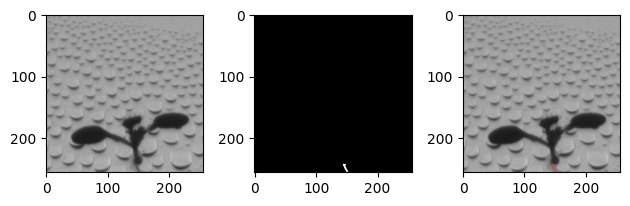

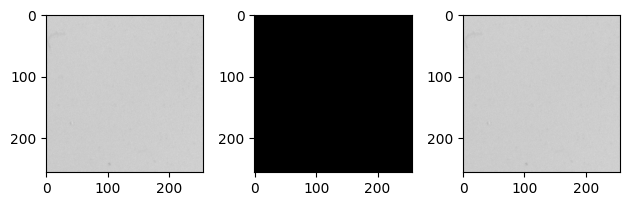

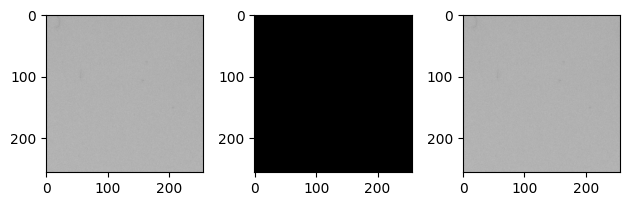

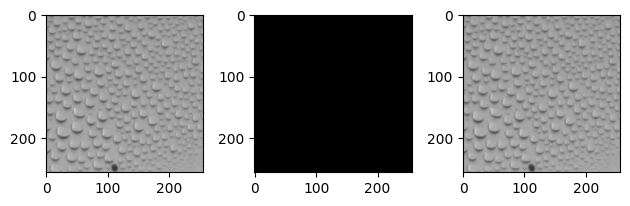

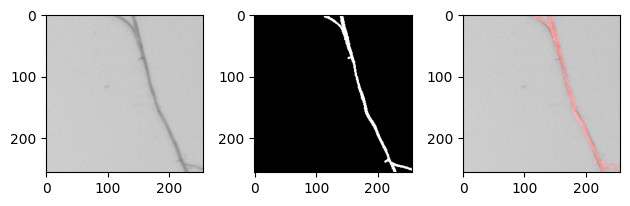

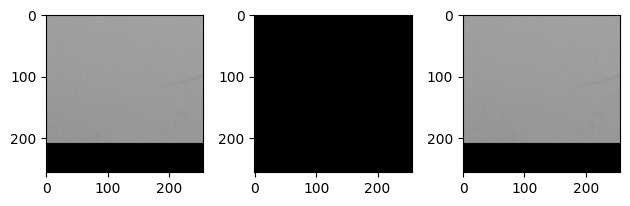

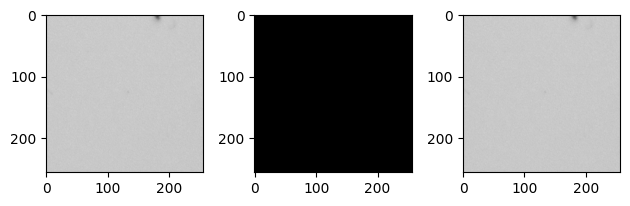

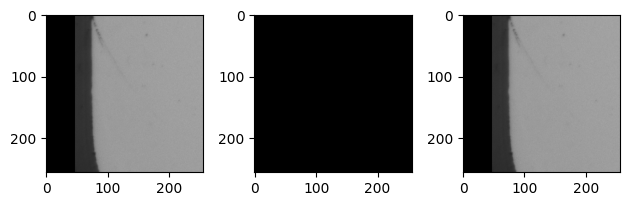

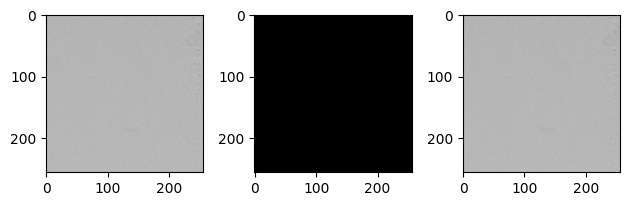

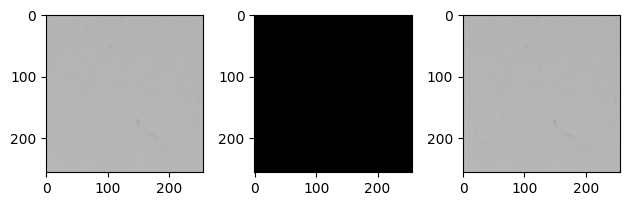

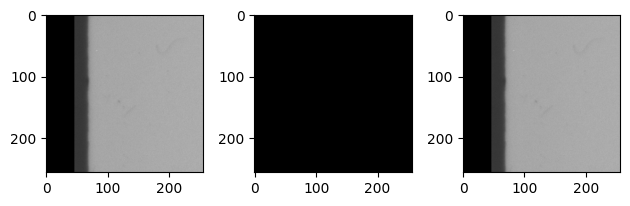

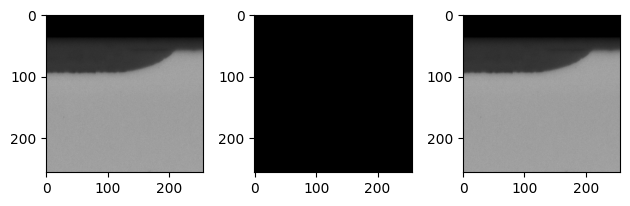

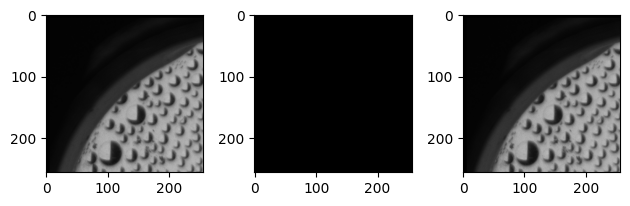

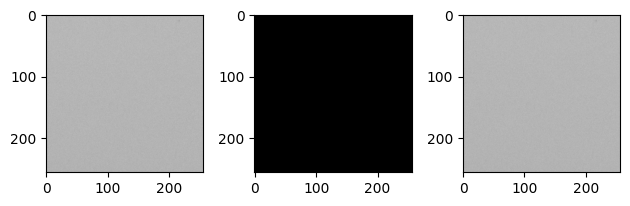

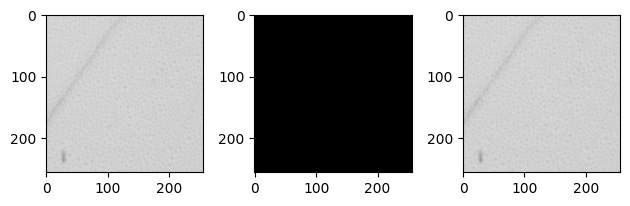

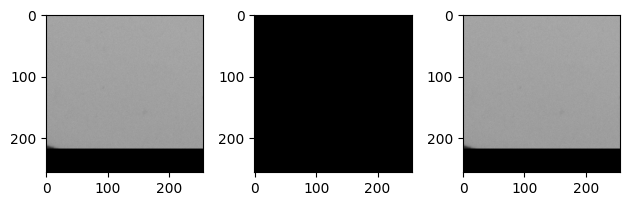

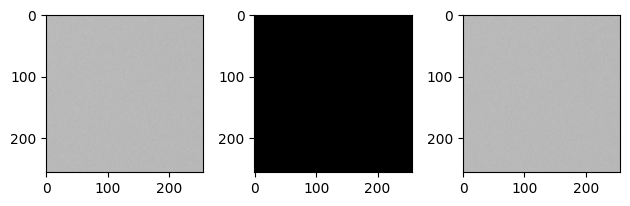

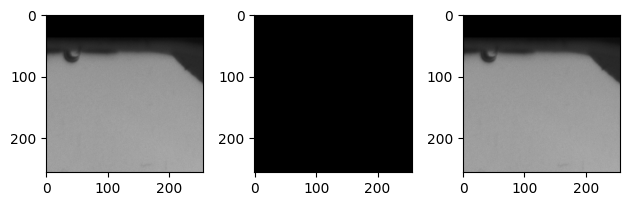

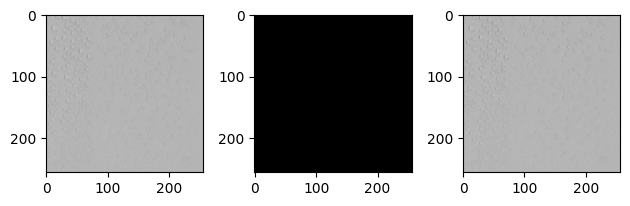

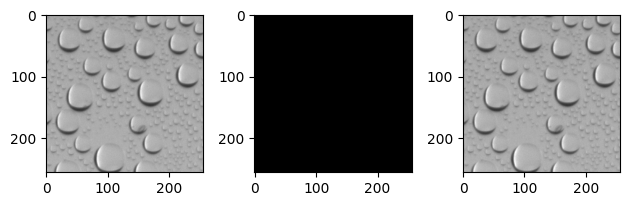

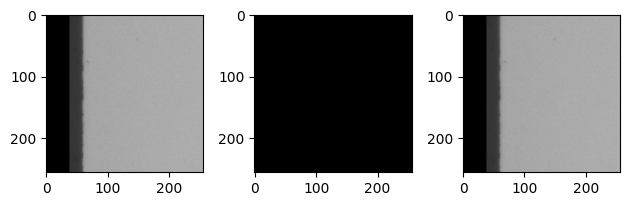

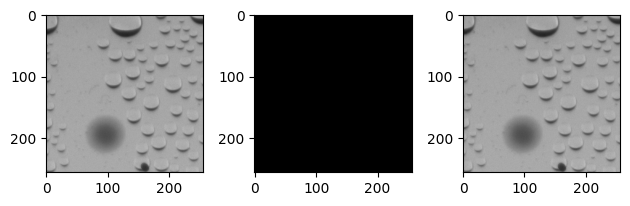

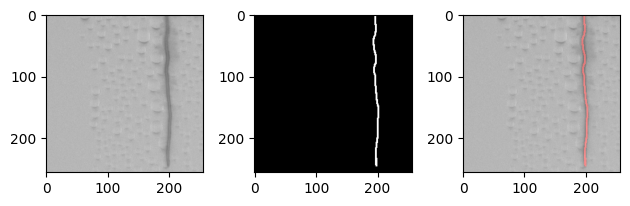

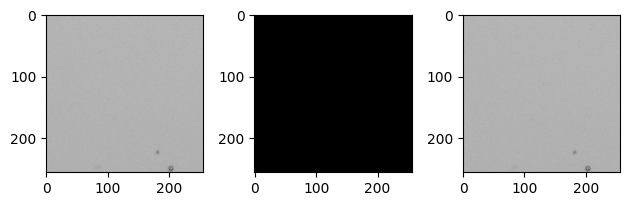

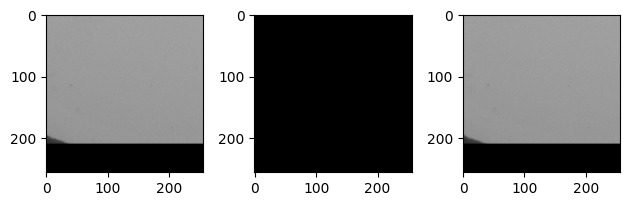

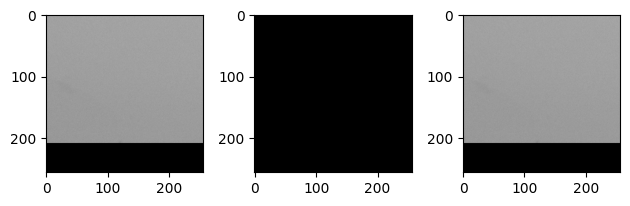

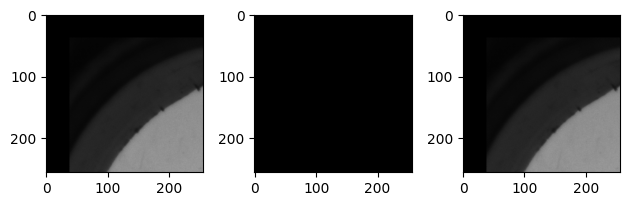

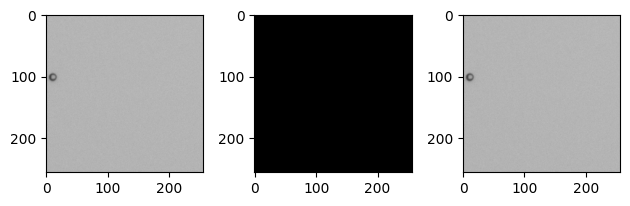

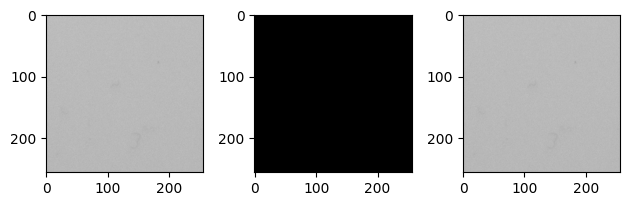

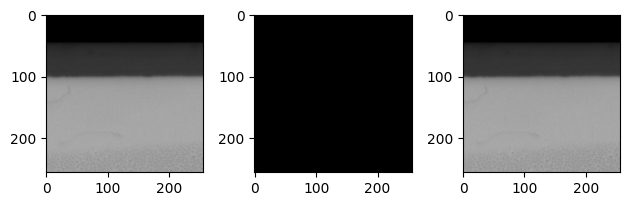

In [52]:
n = 30

indices = random.sample(range(len(img_paths)), k=min(n, len(img_paths)))

for i in indices:
    img_path = img_paths[i]
    mask_path = mask_paths[i]

    # read image and mask
    img = cv2.imread(img_path, 0)
    # Create an RGB version of the grayscale image
    im_rgb = np.dstack([img, img, img])

    root_mask = cv2.imread(mask_path, 0)

    # build red overlay where mask == 1
    root_color = [1, 0, 0]  # red
    overlay_root = np.zeros_like(im_rgb, dtype=float)

    # Transparency level
    alpha = 0.4

    overlay_root[root_mask == 1] = root_color

    # normalize image
    im_overlay = im_rgb / 255.0 

    im_overlay += alpha * overlay_root
    im_overlay = np.clip(im_overlay, 0, 1)

    # plot
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(im_rgb)
    ax[1].imshow(root_mask, cmap='gray')
    ax[2].imshow(im_overlay)
    plt.tight_layout()
    plt.show()

## Multiclass Segmentation

### Create and save patches

In [9]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
patch_dir = 'multiclass_dataset_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [10]:
import os
import glob
import cv2
import numpy as np
from patchify import patchify

def create_and_save_patches(patch_size, scaling_factor):
    roots = ["Y2B_23", "Y2B_24", "Y2B_25"]

    for ds in roots:
        mask_root = f"../Task_2/datasets/{ds}/masks"
        image_split_pairs = []  # list of (image_path, split) where split - {"train", "val"}

        # COLLECT IMAGES AND ASSIGN SPLIT
        if ds == "Y2B_23":
            # images in subfolders "train", "val", "test" -> ALL go to TRAIN
            img_root = f"../Task_2/datasets/{ds}/images"
            images = []
            for sub in ["train", "val", "test"]:
                images.extend(glob.glob(os.path.join(img_root, sub, "*.png")))
            images = sorted(images)
            image_split_pairs = [(p, "train") for p in images]

        elif ds == "Y2B_24":
            # images in one folder -> ALL go to TRAIN
            img_root = f"../Task_2/datasets/{ds}/images"
            all_images = sorted(glob.glob(os.path.join(img_root, "*.png")))
            image_split_pairs = [(p, "train") for p in all_images]

        elif ds == "Y2B_25":
            # filenames start with "train" or "val"
            img_root = f"../Task_2/datasets/{ds}/images"
            all_images = sorted(glob.glob(os.path.join(img_root, "*.png")))
            for p in all_images:
                fname = os.path.basename(p)
                if fname.startswith("train"):
                    split = "train"
                elif fname.startswith("val"):
                    split = "val"
                else:
                    print(f"[{ds}] Skipping {fname}: unknown split prefix (expected 'train' or 'val').")
                    continue
                image_split_pairs.append((p, split))
        else:
            print(f"Unknown dataset root: {ds}, skipping.")
            continue

        # PROCESS EACH IMAGE
        for image_path, split in image_split_pairs:
            base = os.path.basename(image_path)
            stem, _ = os.path.splitext(base)

            # FIND MASK PATHS
            if ds == "Y2B_23":
                root_mask_path  = os.path.join(mask_root, stem + "_root_mask.tif")
                shoot_mask_path = os.path.join(mask_root, stem + "_shoot_mask.tif")
                seed_mask_path  = os.path.join(mask_root, stem + "_seed_mask.tif")

                if not (os.path.exists(root_mask_path)
                        and os.path.exists(shoot_mask_path)
                        and os.path.exists(seed_mask_path)):
                    print(f"Mask(s) missing for {stem}, skipping.")
                    continue
            else:
                # Y2B_24 & Y2B_25: masks in subfolders
                root_candidates  = glob.glob(os.path.join(mask_root, "*", stem + "_root_mask.tif"))
                shoot_candidates = glob.glob(os.path.join(mask_root, "*", stem + "_shoot_mask.tif"))
                seed_candidates  = glob.glob(os.path.join(mask_root, "*", stem + "_seed_mask.tif"))

                if not (root_candidates and shoot_candidates and seed_candidates):
                    print(f"Mask(s) missing for {stem}, skipping.")
                    continue

                root_mask_path  = root_candidates[0]
                shoot_mask_path = shoot_candidates[0]
                seed_mask_path  = seed_candidates[0]

            # ---------- READ IMAGE & MASKS ----------
            image      = cv2.imread(image_path)
            root_mask  = cv2.imread(root_mask_path,  cv2.IMREAD_GRAYSCALE)
            shoot_mask = cv2.imread(shoot_mask_path, cv2.IMREAD_GRAYSCALE)
            seed_mask  = cv2.imread(seed_mask_path,  cv2.IMREAD_GRAYSCALE)

            # crop to petri dish
            image_cropped, (y0, y1, x0, x1) = extract_dish(image)
            root_cropped  = root_mask[y0:y1,  x0:x1]
            shoot_cropped = shoot_mask[y0:y1, x0:x1]
            seed_cropped  = seed_mask[y0:y1,  x0:x1]

            # pad so dimensions are divisible by patch_size
            image_cropped = padder(image_cropped, patch_size)
            root_cropped  = padder(root_cropped,  patch_size)
            shoot_cropped = padder(shoot_cropped, patch_size)
            seed_cropped  = padder(seed_cropped,  patch_size)

            # scaling (if needed)
            if scaling_factor != 1:
                image_cropped = cv2.resize(
                    image_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )
                root_cropped = cv2.resize(
                    root_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )
                shoot_cropped = cv2.resize(
                    shoot_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )
                seed_cropped = cv2.resize(
                    seed_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
                )

            # ensure binary 0/1 for each
            root_bin  = (root_cropped  > 0).astype(np.uint8)
            shoot_bin = (shoot_cropped > 0).astype(np.uint8)
            seed_bin  = (seed_cropped  > 0).astype(np.uint8)

            # BUILD MULTICLASS MASK
            # 0 = background, 1 = root, 2 = shoot, 3 = seed
            multiclass_mask = np.zeros_like(root_bin, dtype=np.uint8)
            multiclass_mask[root_bin  == 1] = 1
            multiclass_mask[shoot_bin == 1] = 2
            multiclass_mask[seed_bin  == 1] = 3

            # PATCHIFY
            img_patches = patchify(image_cropped, (patch_size, patch_size, 3), step=patch_size)
            img_patches = img_patches.reshape(-1, patch_size, patch_size, 3)

            mask_patches = patchify(multiclass_mask, (patch_size, patch_size), step=patch_size)
            mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

            # OUTPUT DIRECTORIES
            if split == "train":
                img_subdir  = "train_images/train"
                mask_subdir = "train_masks/train"
            elif split == "val":
                img_subdir  = "val_images/val"
                mask_subdir = "val_masks/val"
            else:
                raise ValueError(f"Unknown split: {split}")

            # base output paths
            image_patch_base = os.path.join(patch_dir, img_subdir, stem)
            mask_patch_base  = os.path.join(patch_dir, mask_subdir, stem + "_mask")

            # save image patches
            for i, patch in enumerate(img_patches):
                out_path = f"{image_patch_base}_{i}.png"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)

            # save mask patches
            for i, patch in enumerate(mask_patches):
                out_path = f"{mask_patch_base}_{i}.tif"
                os.makedirs(os.path.dirname(out_path), exist_ok=True)
                cv2.imwrite(out_path, patch)


In [11]:
patch_size = 256
scaling_factor = 1

create_and_save_patches(patch_size, scaling_factor)

Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 98.0
Otsu algorithm selected the following threshold: 98.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 103.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Otsu algorithm selected the following threshold: 102.0
Mask(s) miss

In [12]:
img_paths = sorted(glob.glob("multiclass_dataset_patched/train_images/train/*.png"))
mask_paths = sorted(glob.glob("multiclass_dataset_patched/train_masks/train/*.tif"))

print(f"Number of images: {len(img_paths)}")
print(f"Number of masks: {len(mask_paths)}")

Number of images: 57233
Number of masks: 57233


### Small seedlings dataset

#### Create and save patches

In [28]:
import os
import glob
import cv2
import numpy as np
from patchify import patchify

def create_and_save_patches_seedlings(patch_size, scaling_factor):

    mask_root = "../Task_2/datasets/small_seedlings_fixed/masks/"
    img_root  = "../Task_2/datasets/small_seedlings/"
    all_images = sorted(glob.glob(os.path.join(img_root, "*.png.png")))

    # MASKS
    all_root_masks = sorted(
        glob.glob(os.path.join(mask_root, "*-root.tif"))
    )
    all_seed_masks = sorted(
        glob.glob(os.path.join(mask_root, "*-seed.tif"))
    )

    print("Found:")
    print("  images    :", len(all_images))
    print("  root masks:", len(all_root_masks))
    print("  seed masks:", len(all_seed_masks))

    # sanity check
    n = min(len(all_images), len(all_root_masks), len(all_seed_masks))
    if n == 0:
        print("No images or masks found.")
        return

    if not (len(all_images) == len(all_root_masks) == len(all_seed_masks)):
        print("Counts differ! Will only process first", n, "matches.")

    # PROCESS EACH IMAGE
    for idx in range(n):
        image_path     = all_images[idx]
        root_mask_path = all_root_masks[idx]
        seed_mask_path = all_seed_masks[idx]

        base = os.path.basename(image_path)

        # strip chained ".png" endings (handles .png.png)
        stem = base
        while stem.lower().endswith(".png"):
            stem = stem[:-4]

        # ---------- READ IMAGE & MASKS ----------
        image     = cv2.imread(image_path)
        root_mask = cv2.imread(root_mask_path, cv2.IMREAD_GRAYSCALE)
        seed_mask = cv2.imread(seed_mask_path, cv2.IMREAD_GRAYSCALE)

        # crop to petri dish
        image_cropped, (y0, y1, x0, x1) = extract_dish(image)
        root_cropped  = root_mask[y0:y1,  x0:x1]
        seed_cropped  = seed_mask[y0:y1,  x0:x1]

        # pad so dimensions are divisible by patch_size
        image_cropped = padder(image_cropped, patch_size)
        root_cropped  = padder(root_cropped,  patch_size)
        seed_cropped  = padder(seed_cropped,  patch_size)

        # scaling (if needed)
        if scaling_factor != 1:
            image_cropped = cv2.resize(
                image_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
            )
            root_cropped = cv2.resize(
                root_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
            )
            seed_cropped = cv2.resize(
                seed_cropped, (0, 0), fx=scaling_factor, fy=scaling_factor
            )

        # ensure binary 0/1 for each
        root_bin  = (root_cropped  > 0).astype(np.uint8)
        seed_bin  = (seed_cropped  > 0).astype(np.uint8)

        # BUILD MULTICLASS MASK
        # 0 = background, 1 = root, 2 = shoot, 3 = seed
        multiclass_mask = np.zeros_like(root_bin, dtype=np.uint8)
        multiclass_mask[root_bin  == 1] = 1
        multiclass_mask[seed_bin  == 1] = 3

        # PATCHIFY
        img_patches = patchify(image_cropped, (patch_size, patch_size, 3), step=patch_size)
        img_patches = img_patches.reshape(-1, patch_size, patch_size, 3)

        mask_patches = patchify(multiclass_mask, (patch_size, patch_size), step=patch_size)
        mask_patches = mask_patches.reshape(-1, patch_size, patch_size, 1)

        img_subdir  = "train_images/train"
        mask_subdir = "train_masks/train"

        # base output paths
        image_patch_base = os.path.join(patch_dir, img_subdir, stem)
        mask_patch_base  = os.path.join(patch_dir, mask_subdir, stem + "_mask")

        # save image patches
        for i, patch in enumerate(img_patches):
            out_path = f"{image_patch_base}_{i}.png"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            cv2.imwrite(out_path, patch)

        # save mask patches
        for i, patch in enumerate(mask_patches):
            out_path = f"{mask_patch_base}_{i}.tif"
            os.makedirs(os.path.dirname(out_path), exist_ok=True)
            cv2.imwrite(out_path, patch)


In [49]:
# Create a new directory for patches
# Folder name will be blood_cell_dataset_patched instead of blood_cell_dataset
patch_dir = 'multiclass_dataset_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [30]:
patch_size = 256
scaling_factor = 1

create_and_save_patches_seedlings(patch_size, scaling_factor)

Found:
  images    : 21
  root masks: 21
  seed masks: 21
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 101.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 100.0
Otsu algorithm selected the following threshold: 95.0
Otsu algorithm selected the following threshold: 96.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 97.0
Otsu algorithm selected the following threshold: 99.0
Otsu algorithm se

In [53]:
img_paths = sorted(glob.glob("multiclass_dataset_patched/train_images/train/*.png"))
mask_paths = sorted(glob.glob("multiclass_dataset_patched/train_masks/train/*.tif"))

print(f"Number of images: {len(img_paths)}")
print(f"Number of masks: {len(mask_paths)}")

Number of images: 59774
Number of masks: 59774


### Sanity check

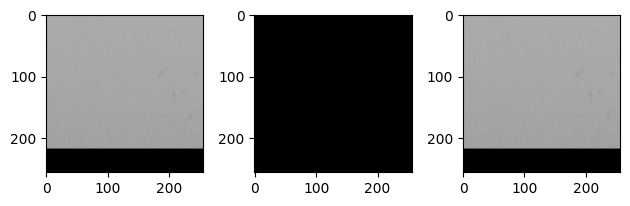

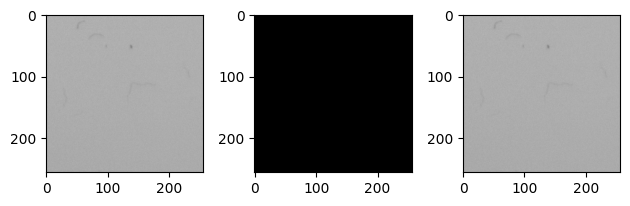

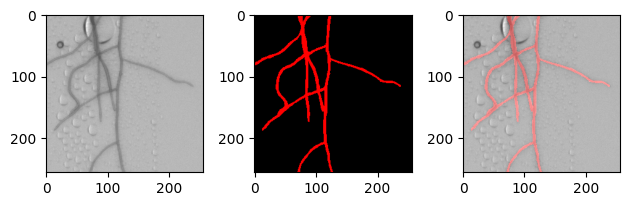

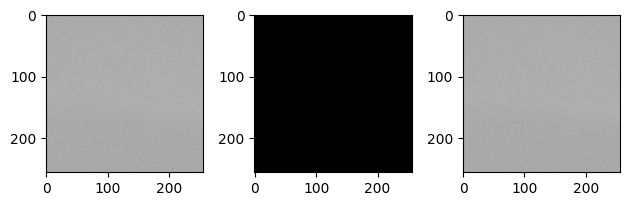

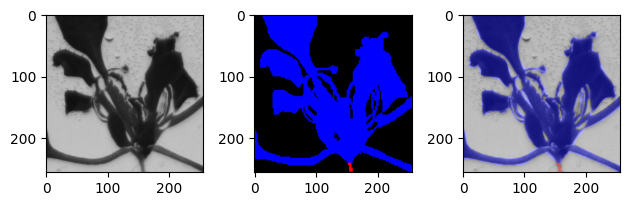

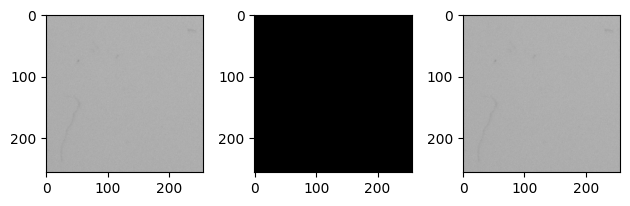

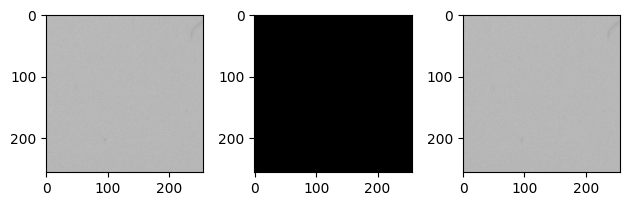

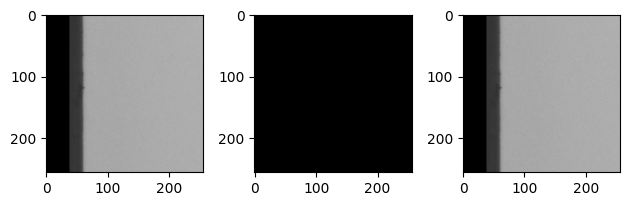

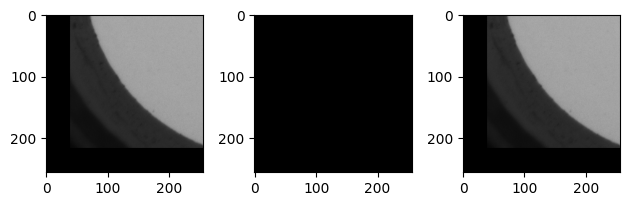

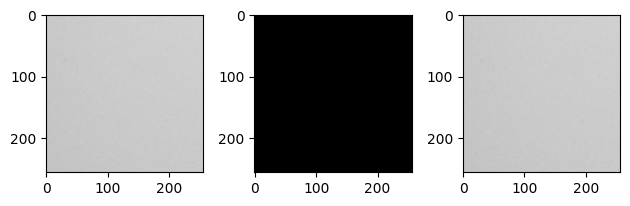

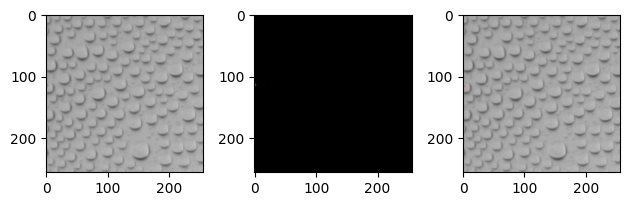

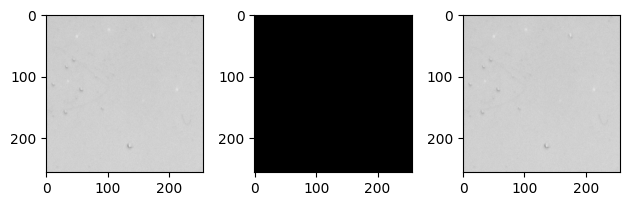

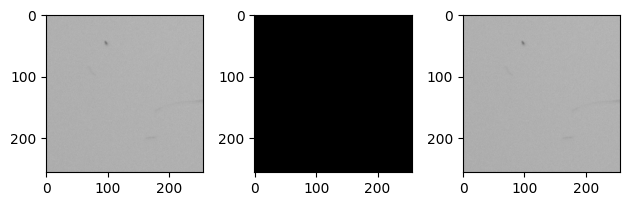

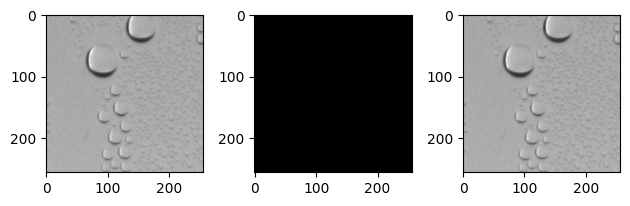

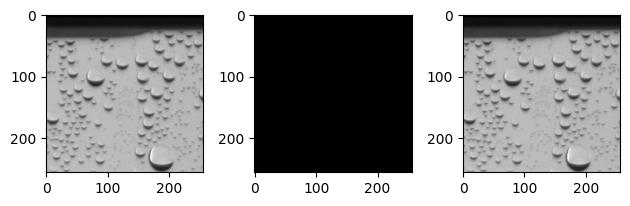

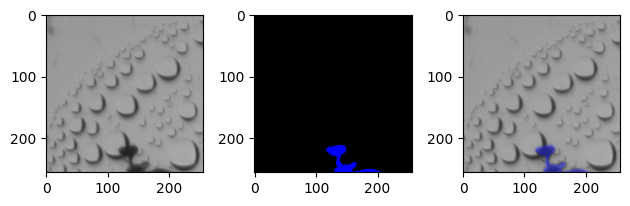

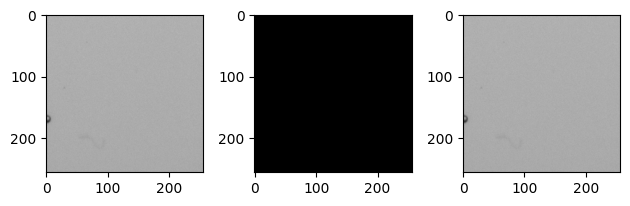

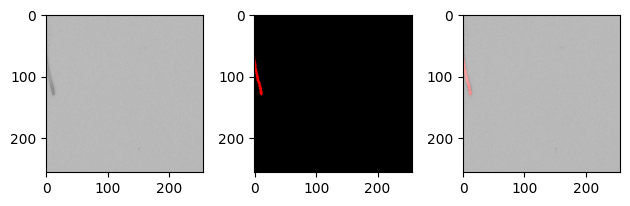

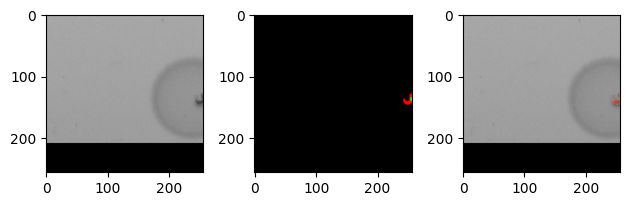

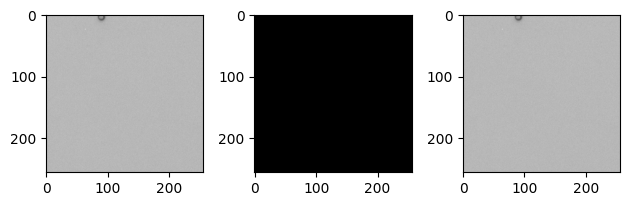

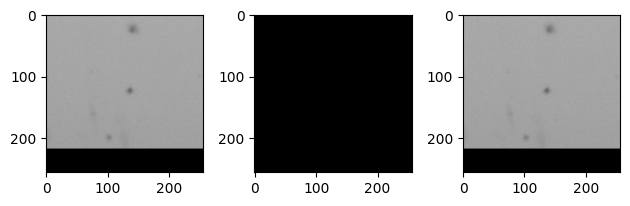

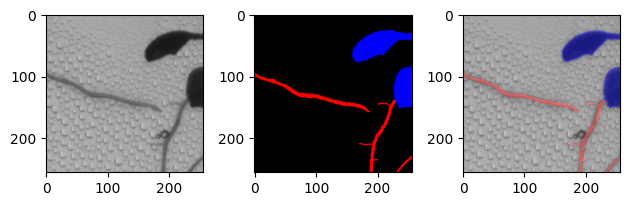

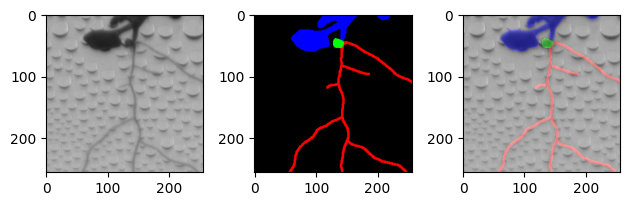

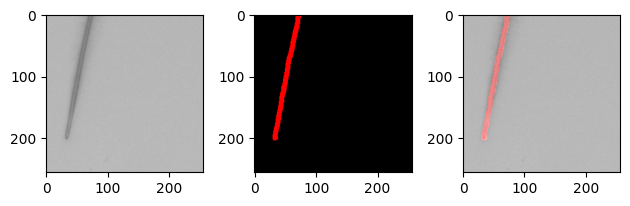

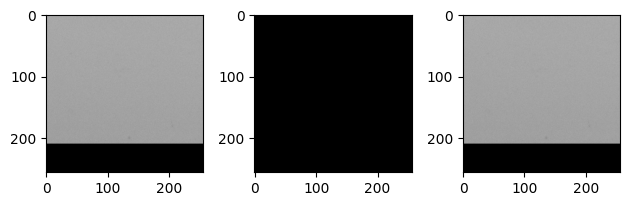

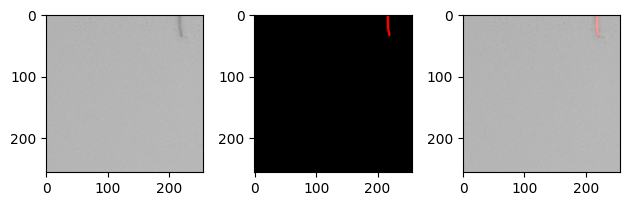

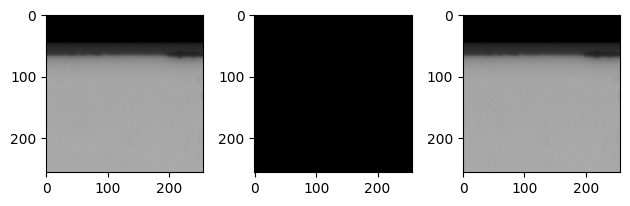

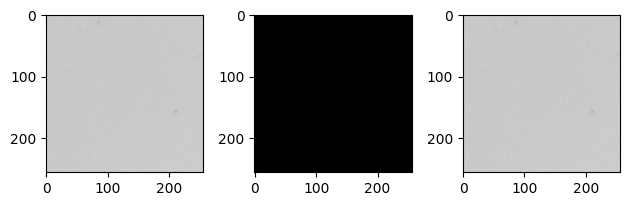

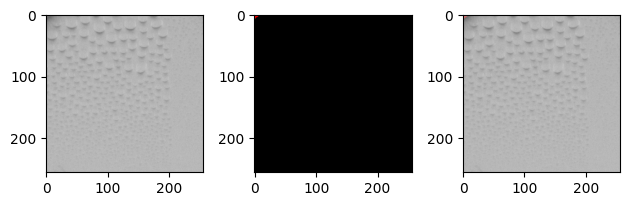

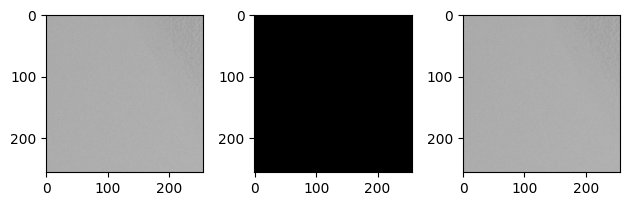

In [13]:
n = 30

indices = random.sample(range(len(img_paths)), k=min(n, len(img_paths)))

for i in indices:
    img_path = img_paths[i]
    mask_path = mask_paths[i]

    # read image and mask
    img = cv2.imread(img_path, 0)
    # Create an RGB version of the grayscale image
    im_rgb = np.dstack([img, img, img])
    
    shoot_color = [0, 0, 1]  # Blue for shoot mask
    seed_color = [0, 1, 0]   # Green for seed mask
    root_color = [1, 0, 0]   # Red for root mask

    mask = cv2.imread(mask_path, 0)

    # build red overlay where mask == 1
    root_color = [1, 0, 0]  # red
    overlay_mask = np.zeros_like(im_rgb, dtype=float)

    # Transparency level
    alpha = 0.4

    overlay_mask[mask == 1] = root_color
    overlay_mask[mask == 2] = shoot_color
    overlay_mask[mask == 3] = seed_color

    # normalize image
    im_overlay = im_rgb / 255.0 

    im_overlay += alpha * overlay_mask
    im_overlay = np.clip(im_overlay, 0, 1)  # Clip values to keep them within [0, 1]

    # plot
    fig, ax = plt.subplots(1, 3)

    ax[0].imshow(im_rgb)
    ax[1].imshow(overlay_mask, cmap='gray')
    ax[2].imshow(im_overlay)
    plt.tight_layout()
    plt.show()